In [1]:
import pandas as pd 
import numpy as np
from torchtext.datasets import IWSLT2016
from torchtext.vocab import build_vocab_from_iterator
from transformers import BertTokenizer
from torch.nn.utils.rnn import pad_sequence
import torch
import os
from torch.utils.data import Dataset,DataLoader,TensorDataset
import matplotlib.pyplot as plt 

In [2]:
src_lang='en'
tgt_lang='zh'
max_src_len=128
max_tgt_len=128
data_dir='./data/news-commentary-v16.en-zh.tsv'
src_tokenizer_dir='./models/bert-base-uncased'
tgt_tokenizer_dir='./models/bert-base-chinese'
src_vocab_dir='./checkpoints/vocabs/src_en_vocab.pkl'
tgt_vocab_dir='./checkpoints/vocabs/tgt_zh_vocab.pkl'

In [3]:
data=pd.read_csv(data_dir,sep='\t',encoding='utf-8',names=[src_lang,tgt_lang])
data

,en,zh
0,1929 or 1989?,1929年还是1989年?
1,PARIS – As the economic crisis deepens and wid...,巴黎-随着经济危机不断加深和蔓延，整个世界一直在寻找历史上的类似事件希望有助于我们了解目前正...
2,"At the start of the crisis, many people likene...",一开始，很多人把这次危机比作1982年或1973年所发生的情况，这样得类比是令人宽心的，因为...
3,"Today, the mood is much grimmer, with referenc...",如今人们的心情却是沉重多了，许多人开始把这次危机与1929年和1931年相比，即使一些国家政...
4,The tendency is either excessive restraint (Eu...,目前的趋势是，要么是过度的克制（欧洲 ） ， 要么是努力的扩展（美国 ） 。
...,...,...
322269,"At the same time, Zuma’s revolutionary generat...",同时，祖马革命的一代似乎对领导打破种族隔离制度15年后的南非，还不适应。
322270,"In a region that reveres the elderly, Zuma’s a...",在一个尊敬老人的地区，祖马对其乡下传统的依恋，必须和对南非年青人的爱好所持的平等而开放态度相平衡。
322271,Three in ten South Africans are younger than 1...,在南非，每10个人中就有三个人的年龄小于15岁，这意味着，这些人从来没有在种族隔离制度下生活过。
322272,Somehow Zuma must find a way to honor his own ...,在某种程度上，祖马在给予那些心灵每天都会被阶层差异刺痛以及渴望物质利益的广大民众权利的同时，...


In [4]:
data=data.dropna(axis=0).reset_index(drop=True)
data

,en,zh
0,1929 or 1989?,1929年还是1989年?
1,PARIS – As the economic crisis deepens and wid...,巴黎-随着经济危机不断加深和蔓延，整个世界一直在寻找历史上的类似事件希望有助于我们了解目前正...
2,"At the start of the crisis, many people likene...",一开始，很多人把这次危机比作1982年或1973年所发生的情况，这样得类比是令人宽心的，因为...
3,"Today, the mood is much grimmer, with referenc...",如今人们的心情却是沉重多了，许多人开始把这次危机与1929年和1931年相比，即使一些国家政...
4,The tendency is either excessive restraint (Eu...,目前的趋势是，要么是过度的克制（欧洲 ） ， 要么是努力的扩展（美国 ） 。
...,...,...
313668,Their achievement remains one of the greatest ...,这一代人的成就是现代��史上最伟大的成就之一。
313669,"At the same time, Zuma’s revolutionary generat...",同时，祖马革命的一代似乎对领导打破种族隔离制度15年后的南非，还不适应。
313670,"In a region that reveres the elderly, Zuma’s a...",在一个尊敬老人的地区，祖马对其乡下传统的依恋，必须和对南非年青人的爱好所持的平等而开放态度相平衡。
313671,Three in ten South Africans are younger than 1...,在南非，每10个人中就有三个人的年龄小于15岁，这意味着，这些人从来没有在种族隔离制度下生活过。


In [5]:
src_tokenizer=BertTokenizer.from_pretrained(src_tokenizer_dir)
tgt_tokenizer=BertTokenizer.from_pretrained(tgt_tokenizer_dir)

In [6]:
UNK,PAD,BOS,EOS=['[UNK]','[PAD]','[BOS]','[EOS]']
UNK,PAD,BOS,EOS

('[UNK]', '[PAD]', '[BOS]', '[EOS]')

In [7]:
class TextTransform(object):
    def __init__(self,tokenizer,max_seq_len,unk_token,pad_token,bos_token,eos_token,truncate_first=False):
        self.special_tokens=[unk_token,pad_token,bos_token,eos_token]
        self.unk_idx,self.pad_idx,self.bos_idx,self.eos_idx=range(4)
        self.tokenizer=tokenizer
        assert max_seq_len>=2
        self.max_seq_len=max_seq_len-2
        self.truncate_first=truncate_first
        self.vocab=None

    def build_vocab(self,corpus,save_path):
        def yield_tokens(corpus,tokenizer):
            for sentence in corpus:
                yield tokenizer.tokenize(sentence)
        if os.path.exists(save_path):
            print('vocab areadly existed!')
            self.vocab=torch.load(save_path)
        else:
            corpus_tokens=yield_tokens(corpus,self.tokenizer)
            self.vocab=build_vocab_from_iterator(corpus_tokens,min_freq=1,specials=self.special_tokens,special_first=True)
            torch.save(self.vocab,save_path)
            print(f'vocabulary save to {save_path}')
        self.vocab.set_default_index(self.unk_idx)
        print(f'vocabulary size: {len(self.vocab)}')

    def pad(self,seq):
        padded_seq=[self.bos_idx]+(seq[-self.max_seq_len:] if self.truncate_first else seq[:self.max_seq_len])+[self.eos_idx]+[self.pad_idx]*max(0,self.max_seq_len-len(seq))
        return padded_seq

    def vocab_size(self):
        return len(self.vocab)

    def __call__(self,sentence):
        tokens=self.tokenizer.tokenize(sentence)
        token_ids=self.vocab(tokens)
        input_ids=self.pad(token_ids)
        return input_ids

In [8]:
src_textTransform=TextTransform(src_tokenizer,max_src_len,UNK,PAD,BOS,EOS)
src_textTransform.build_vocab(data[src_lang].tolist(),src_vocab_dir)

vocabulary save to ./checkpoints/vocabs/src_en_vocab.pkl
vocabulary size: 24454


In [9]:
src_textTransform('I 铪 love you ')

[2,
 140,
 0,
 3926,
 350,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [10]:
tgt_textTransform=TextTransform(tgt_tokenizer,max_tgt_len,UNK,PAD,BOS,EOS)
tgt_textTransform.build_vocab(data[tgt_lang].tolist(),tgt_vocab_dir)

vocabulary save to ./checkpoints/vocabs/tgt_zh_vocab.pkl
vocabulary size: 6870


In [11]:
tgt_textTransform('我爱你 铪')

[2,
 70,
 885,
 626,
 0,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [12]:
def get_tensor_data(data,src_trans,tgt_trans):
    src_data,tgt_data=[],[]
    for i in range(len(data)):
        if (i+1)%10000==0:
            print(f"get {i+1} data")
        src_data.append(src_trans(data[src_lang][i]))
        tgt_data.append(tgt_trans(data[tgt_lang][i]))
    return torch.tensor(src_data),torch.tensor(tgt_data)

In [13]:
src_data,tgt_data=get_tensor_data(data,src_textTransform,tgt_textTransform)

get 10000 data
get 20000 data
get 30000 data
get 40000 data
get 50000 data
get 60000 data
get 70000 data
get 80000 data
get 90000 data
get 100000 data
get 110000 data
get 120000 data
get 130000 data
get 140000 data
get 150000 data
get 160000 data
get 170000 data
get 180000 data
get 190000 data
get 200000 data
get 210000 data
get 220000 data
get 230000 data
get 240000 data
get 250000 data
get 260000 data
get 270000 data
get 280000 data
get 290000 data
get 300000 data
get 310000 data


NameError: name 'toech' is not defined

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,TensorDataset
from utils import ScheduledOptimizer
import numpy as np

In [2]:
class M(nn.Module):
    def __init__(self):
        super(M, self).__init__()
        self.fc = nn.Linear(100, 100)

    def forward(self, x):
        return self.fc(x)

In [9]:
d_model=512
batch_size=200
epochs=10
data=torch.load('./data/train_data_cache.pkl')
dataset=TensorDataset(data['src'],data['tgt'])
dataloader=DataLoader(dataset,batch_size=batch_size)
total_step=len(dataloader)*epochs
warmup_step=int(total_step*0.1)
print(total_step,warmup_step)
model = M()
optimizer = Adam(model.parameters())
sch_optim = ScheduledOptimizer(optimizer, d_model, warmup_step)


14120 1412


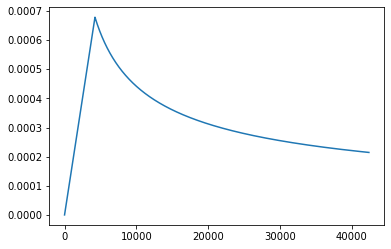

In [4]:
lr_list = []
for step in range(total_step):
    sch_optim.update_lr()
    lr_list.append(sch_optim.get_lr()[0])
    
plt.plot(range(len(lr_list)), lr_list)

In [5]:
print(lr_list[0],lr_list[-1],np.max(lr_list),np.argmax(lr_list))

1.6029910308060072e-07 0.00021472719148048154 0.0006790270006494246 4235


In [6]:
# print(lr_list[0],lr_list[-1],np.max(lr_list),np.argmax(lr_list))
# 8.329385728299636e-07 0.00037191840541076496 0.0011761092648359087 1411

In [7]:
(512*42360)**(-0.5)

0.00021472719148048151

In [8]:
512**(-0.5)*4000**(-1.5)

1.746928107421711e-07

In [11]:
max_seq=10
x=torch.arange(1, max_seq+1, dtype=torch.long).unsqueeze(0)
x

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])

In [14]:
y=torch.tensor([0,0,0,0,0,1,0,0,0,0]).bool()
y

tensor([False, False, False, False, False,  True, False, False, False, False])

In [17]:
x.masked_fill(~y,max_seq).min(1)

torch.return_types.min(
values=tensor([6]),
indices=tensor([5]))